In [ ]:
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
import logging
from keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import  ParameterSampler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, root_mean_squared_error

# Procesiranje podatkov

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

df.sort_values(by=['datetime'], inplace=True)
df.head()

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds
0,2024-05-02 20:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,pretežno oblačno
1,2024-05-02 21:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,delno oblačno
2,2024-05-02 22:00:00,8.0,11.0,0.4,1009.0,84.0,13.0,pretežno oblačno
3,2024-05-02 23:00:00,9.0,10.0,0.0,1009.0,95.0,4.0,delno oblačno
4,2024-05-03 00:00:00,9.0,10.0,0.0,1009.0,93.0,3.0,delno oblačno


Zapolnitev manjkajočih vrednosti

In [ ]:
df.isnull().sum()

,0
datetime,0
PM10,53
temperature,53
rain,53
pressure,54
precipitation,53
wind_speed,53
clouds,53


In [ ]:
df

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds
0,2024-05-02 20:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,pretežno oblačno
1,2024-05-02 21:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,delno oblačno
2,2024-05-02 22:00:00,8.0,11.0,0.4,1009.0,84.0,13.0,pretežno oblačno
3,2024-05-02 23:00:00,9.0,10.0,0.0,1009.0,95.0,4.0,delno oblačno
4,2024-05-03 00:00:00,9.0,10.0,0.0,1009.0,93.0,3.0,delno oblačno
...,...,...,...,...,...,...,...,...
3006,2024-09-05 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3007,2024-09-05 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008,2024-09-05 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3009,2024-09-05 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
if 'clouds' in df.columns:
    cloud_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) #neznane -1
    df['clouds_encoded'] = cloud_encoder.fit_transform(df[['clouds']].fillna("unknown"))
else:
    df['clouds_encoded'] = np.nan

columns_with_nulls = df.columns[df.isnull().any()].tolist()

numeric_columns = ['PM10', 'temperature', 'rain', 'pressure', 'precipitation', 'wind_speed']
categorical_columns = ['clouds']

for column in numeric_columns:
    if column in columns_with_nulls:
        train_data = df[df[column].notna()]
        features = [col for col in numeric_columns + ['clouds_encoded'] if col != column]
        X_train = train_data[features]
        y_train = train_data[column]

        model = HistGradientBoostingRegressor(random_state=42)
        model.fit(X_train, y_train)

        missing_data = df[df[column].isna()]
        if not missing_data.empty:
            X_missing = missing_data[features]
            predictions = model.predict(X_missing)
            df.loc[missing_data.index, column] = predictions

for column in categorical_columns:
    if column in columns_with_nulls:
        train_data = df[df[column].notna()]
        features = numeric_columns + ['clouds_encoded']
        X_train = train_data[features]
        y_train = cloud_encoder.transform(train_data[[column]])

        model = HistGradientBoostingClassifier(random_state=42)
        model.fit(X_train, y_train.ravel())

        missing_data = df[df[column].isna()]
        if not missing_data.empty:
            X_missing = missing_data[features]
            predictions = model.predict(X_missing)
            predicted_categories = cloud_encoder.inverse_transform(predictions.reshape(-1, 1))
            df.loc[missing_data.index, column] = predicted_categories

df = df.drop(columns=['clouds_encoded'])


In [ ]:
df.isnull().sum()

,0
datetime,0
PM10,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds,0


In [ ]:
df = pd.get_dummies(df, columns=['clouds'])

In [ ]:
df.head()

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds_delno oblačno,clouds_jasno,clouds_oblačno,clouds_pretežno oblačno
0,2024-05-02 20:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,False,False,False,True
1,2024-05-02 21:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,True,False,False,False
2,2024-05-02 22:00:00,8.0,11.0,0.4,1009.0,84.0,13.0,False,False,False,True
3,2024-05-02 23:00:00,9.0,10.0,0.0,1009.0,95.0,4.0,True,False,False,False
4,2024-05-03 00:00:00,9.0,10.0,0.0,1009.0,93.0,3.0,True,False,False,False


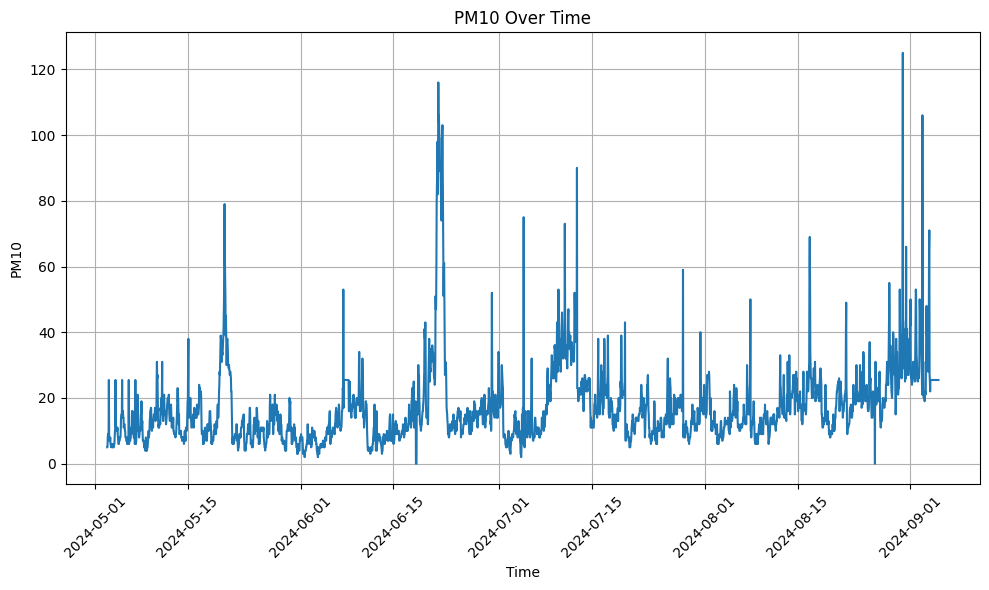

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['PM10'])
plt.xlabel('Time')
plt.ylabel('PM10')
plt.title('PM10 Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ustvarjanje značilnic

In [ ]:
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['pressure_wind_interaction'] = df['pressure'] * df['wind_speed']

df.head()

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds_delno oblačno,clouds_jasno,clouds_oblačno,clouds_pretežno oblačno,month,day_of_week,is_weekend,pressure_wind_interaction
0,2024-05-02 20:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,False,False,False,True,5,3,0,3024.0
1,2024-05-02 21:00:00,5.0,11.0,0.0,1008.0,87.0,3.0,True,False,False,False,5,3,0,3024.0
2,2024-05-02 22:00:00,8.0,11.0,0.4,1009.0,84.0,13.0,False,False,False,True,5,3,0,13117.0
3,2024-05-02 23:00:00,9.0,10.0,0.0,1009.0,95.0,4.0,True,False,False,False,5,3,0,4036.0
4,2024-05-03 00:00:00,9.0,10.0,0.0,1009.0,93.0,3.0,True,False,False,False,5,4,0,3027.0


In [ ]:
df.isnull().sum()

,0
datetime,0
PM10,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds_delno oblačno,0
clouds_jasno,0
clouds_oblačno,0


Popravljanje izkrivljenih podatkov

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'PM10'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'rain'}>,
        <Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'precipitation'}>],
       [<Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day_of_week'}>],
       [<Axes: title={'center': 'is_weekend'}>,
        <Axes: title={'center': 'pressure_wind_interaction'}>, <Axes: >]],
      dtype=object)

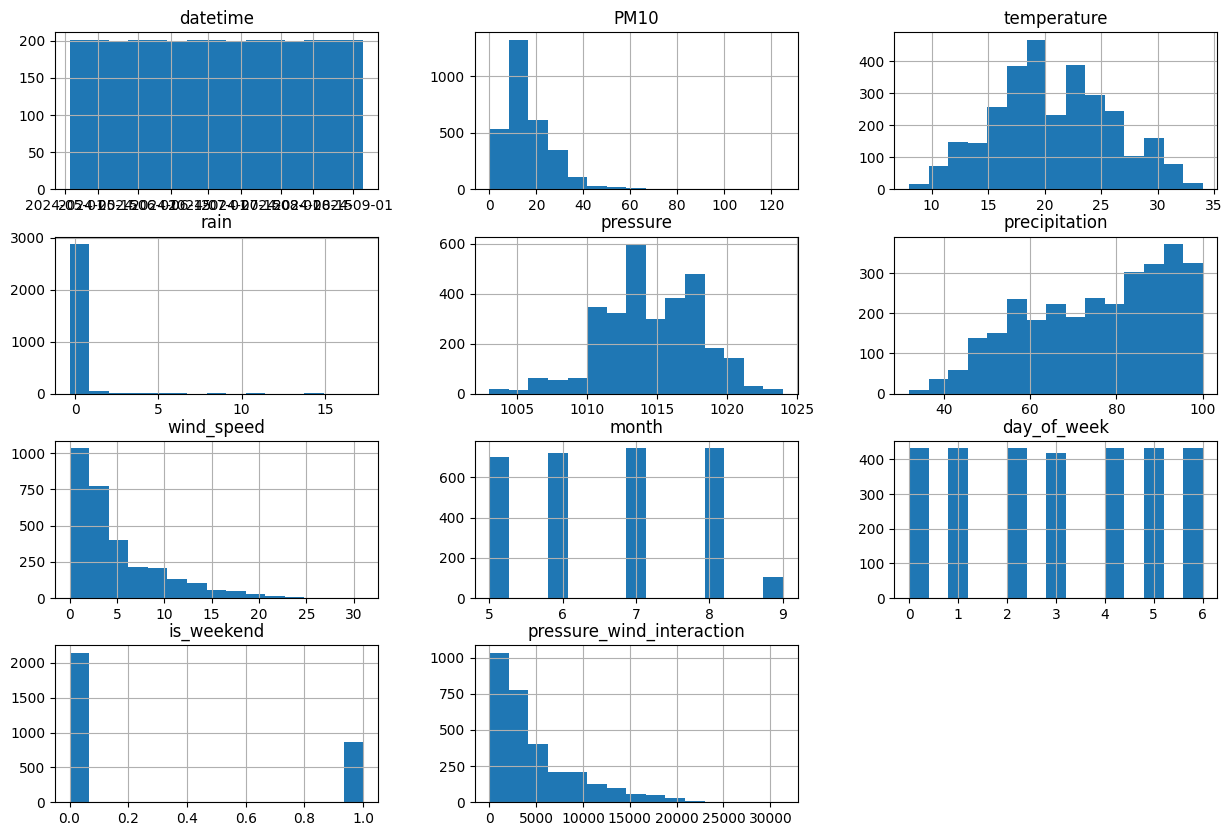

In [ ]:
df.hist(bins=15, figsize=(15, 10))

In [ ]:
#df['PM10'].skew()

3.1976715231769037

In [ ]:
df['PM10'] = np.log1p(df['PM10'])
df['rain'] = np.log1p(df['rain'])
df['wind_speed'] = np.log1p(df['wind_speed'])
df['pressure_wind_interaction'] = np.log1p(df['pressure_wind_interaction'])

In [ ]:
df.isnull().sum()

,0
datetime,0
PM10,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds_delno oblačno,0
clouds_jasno,0
clouds_oblačno,0


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'PM10'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'rain'}>,
        <Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'precipitation'}>],
       [<Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day_of_week'}>],
       [<Axes: title={'center': 'is_weekend'}>,
        <Axes: title={'center': 'pressure_wind_interaction'}>, <Axes: >]],
      dtype=object)

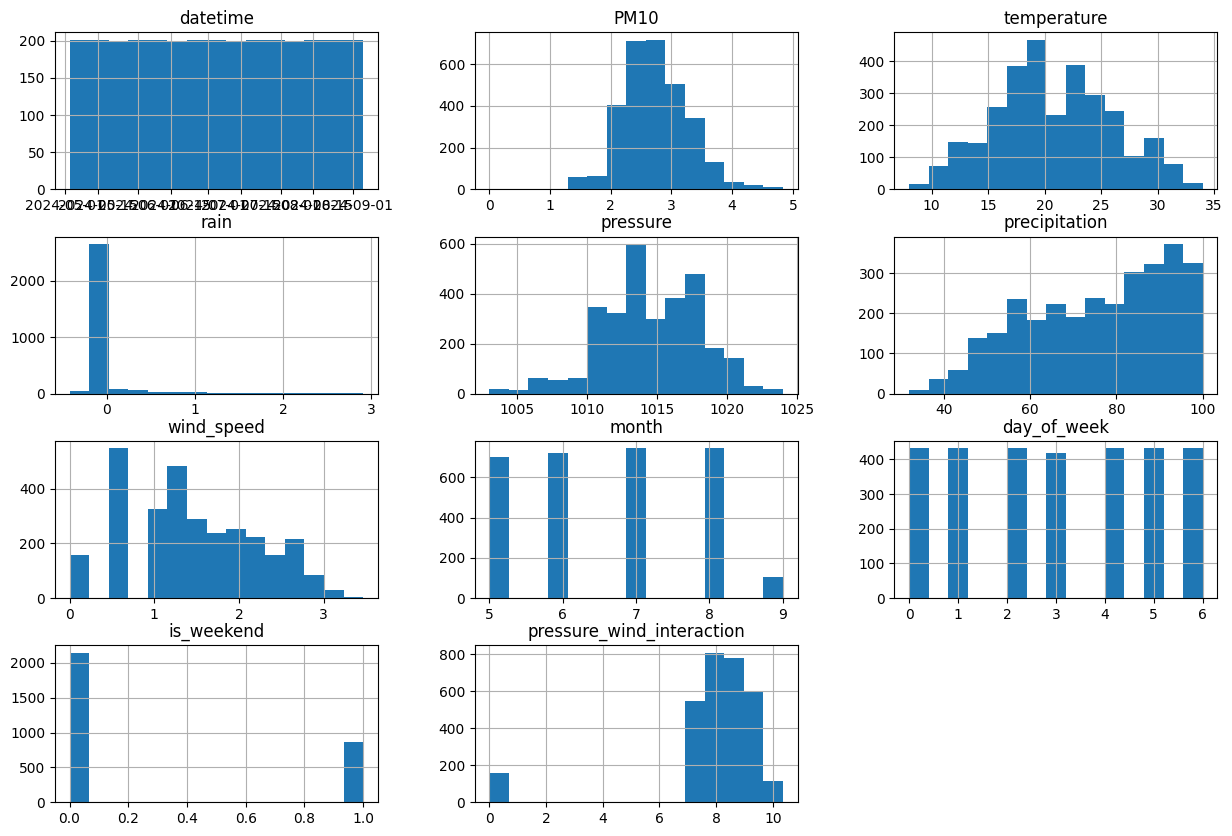

In [ ]:
df.hist(bins=15, figsize=(15, 10))

Standardizacija/Normalizacija vrednosti


In [ ]:
minmax_columns = ['rain','precipitation','pressure_wind_interaction']
standard_columns = ['PM10','temperature','pressure','wind_speed']

scaler_metadata = {
    "minmax_columns": minmax_columns,
    "standard_columns": standard_columns
}

scaler_minmax = MinMaxScaler()
scaler_minmax.fit(df[minmax_columns])

scaler_standard = StandardScaler()
scaler_standard.fit(df[standard_columns])

joblib.dump(scaler_minmax, "scaler_minmax.pkl")
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_metadata, "scaler_metadata.pkl")

['scaler_metadata.pkl']

In [ ]:
df.head()

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds_delno oblačno,clouds_jasno,clouds_oblačno,clouds_pretežno oblačno,month,day_of_week,is_weekend,pressure_wind_interaction
0,2024-05-02 20:00:00,1.791759,11.0,0.000000,1008.0,87.0,1.386294,False,False,False,True,5,3,0,8.014666
1,2024-05-02 21:00:00,1.791759,11.0,0.000000,1008.0,87.0,1.386294,True,False,False,False,5,3,0,8.014666
2,2024-05-02 22:00:00,2.197225,11.0,0.336472,1009.0,84.0,2.639057,False,False,False,True,5,3,0,9.481741
3,2024-05-02 23:00:00,2.302585,10.0,0.000000,1009.0,95.0,1.609438,True,False,False,False,5,3,0,8.303257
4,2024-05-03 00:00:00,2.302585,10.0,0.000000,1009.0,93.0,1.386294,True,False,False,False,5,4,0,8.015658


Izbira značilnic

Columns to analyze: ['temperature', 'rain', 'pressure', 'precipitation', 'wind_speed', 'clouds_delno oblačno', 'clouds_jasno', 'clouds_oblačno', 'clouds_pretežno oblačno', 'month', 'day_of_week', 'is_weekend', 'pressure_wind_interaction']
Number of information gain scores: 13


<Axes: >

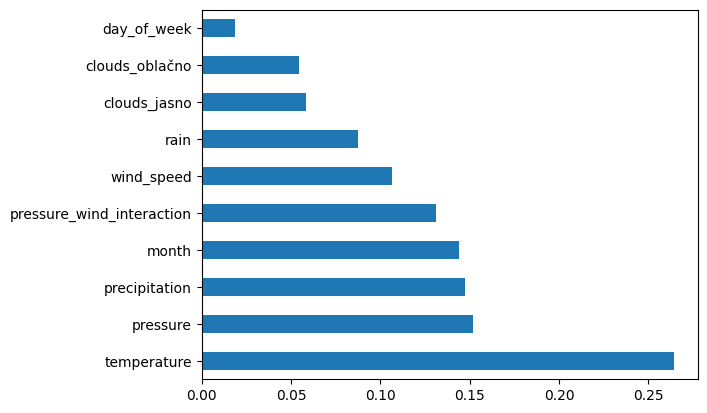

In [ ]:
cols = df.columns.tolist()
cols.remove('PM10')
cols.remove('datetime')

print("Columns to analyze:", cols)

information_gain_scores = mutual_info_regression(df[cols], df['PM10'])
print("Number of information gain scores:", len(information_gain_scores))

feature_importances = pd.Series(information_gain_scores, index=cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

feature_importances.head(10).plot.barh()

# Izgradnja napovednega modela


In [ ]:
data = df['PM10']
time_series = data.values.reshape(-1, 1)
time_series.shape

(3011, 1)

In [ ]:
data_split = round(len(time_series) * 0.2)
train_data = time_series[:-data_split]
test_data = time_series[-data_split:]

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (2409, 1)
Testing data shape: (602, 1)


Normalizacija podatkov

In [ ]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

Funkcija za kreiranje sliding windowa

In [ ]:
def slidding_window(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [ ]:
window_size = 48
X_train, y_train = slidding_window(train_data, window_size)
X_test, y_test = slidding_window(test_data, window_size)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Oblika učnih podatkov: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Oblika testnih podatkov: X_test: {X_test.shape}, y_test: {y_test.shape}")

Oblika učnih podatkov: X_train: (2361, 1, 48), y_train: (2361, 1)
Oblika testnih podatkov: X_test: (554, 1, 48), y_test: (554, 1)


Ustvarjanje modelov

Po zagonu spodnje kode sem našel najboljše parametere za napovedni model:


*   Best Model Type: LSTM
*   Best Units: 64
*   Best Optimizer: adam
*   Best Activation: tanh
*   Best Batch Size: 32
*   Best Epochs: 25
*   Best Dropout Rate: 0.2
*   Best Loss: 0.0051





In [ ]:
def create_lstm_model(units=32, optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential(name="LSTM")
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def create_simple_rnn_model(units=32, optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential(name="RNN")
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def create_gru_model(units=32, optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential(name="GRU")
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'model_type': ['LSTM', 'RNN', 'GRU'],
    'units': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop', 'SGD'],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 25, 50],
    'dropout_rate': [0.2, 0.3, 0.4]
}

best_model = None
best_score = float('inf')
best_params = None

n_iter = 300
param_sampler = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

for params in param_sampler:
    if params['model_type'] == 'LSTM':
        model = create_lstm_model(units=params['units'],
                                   optimizer=params['optimizer'],
                                   activation=params['activation'],
                                   dropout_rate=params['dropout_rate'])
    elif params['model_type'] == 'RNN':
        model = create_simple_rnn_model(units=params['units'],
                                         optimizer=params['optimizer'],
                                         activation=params['activation'],
                                         dropout_rate=params['dropout_rate'])
    elif params['model_type'] == 'GRU':
        model = create_gru_model(units=params['units'],
                                  optimizer=params['optimizer'],
                                  activation=params['activation'],
                                  dropout_rate=params['dropout_rate'])

    history = model.fit(X_train, y_train,
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                        verbose=0)

    loss = model.evaluate(X_test, y_test, verbose=0)

    print(f"Evaluated {params}: Loss = {loss:.4f}")

    if loss < best_score:
        best_score = loss
        best_model = model
        best_params = params

print(f"Best Model Type: {best_params['model_type']}")
print(f"Best Units: {best_params['units']}")
print(f"Best Optimizer: {best_params['optimizer']}")
print(f"Best Activation: {best_params['activation']}")
print(f"Best Batch Size: {best_params['batch_size']}")
print(f"Best Epochs: {best_params['epochs']}")
print(f"Best Dropout Rate: {best_params['dropout_rate']}")
print(f"Best Loss: {best_score:.4f}")

In [ ]:
def recreate_best_lstm_model():
    units = 32 
    optimizer = Adam(learning_rate=0.001)
    activation = 'tanh'
    dropout_rate = 0.4

    model = Sequential(name="Best_LSTM_Model")
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dense(units=64, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

best_lstm_model = recreate_best_lstm_model()

history = best_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

loss = best_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Recreated Best Model Loss: {loss:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1314 - val_loss: 0.0156
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0101
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0107 - val_loss: 0.0069
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0050
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.003

In [ ]:
def plot_history(history, model_name):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title(f'{model_name} Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

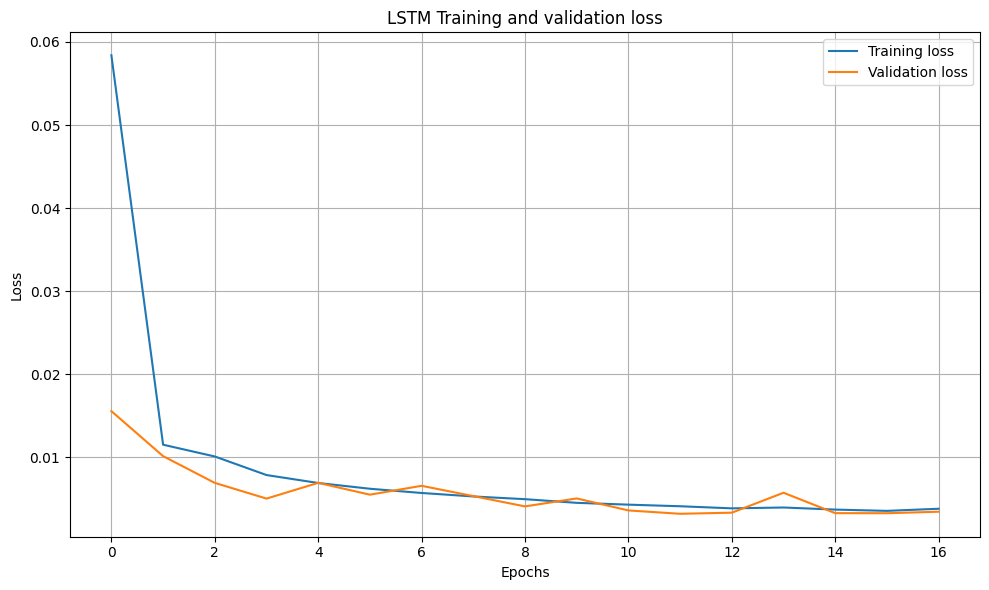

In [ ]:
plot_history(history, 'LSTM')

In [ ]:
vdf = pd.read_csv("/content/drive/MyDrive/validation.csv")
vdf['datetime'] = pd.to_datetime(vdf['datetime'])

vdf.sort_values(by=['datetime'], inplace=True)

vdf.head()

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds
0,2024-09-05 07:00:00,20.0,19.0,0.0,1013.0,80.0,4.0,pretežno oblačno
1,2024-09-05 08:00:00,38.0,20.0,0.0,1013.0,76.0,4.0,delno oblačno
2,2024-09-05 09:00:00,33.0,21.0,0.0,1012.0,74.0,3.0,delno oblačno
3,2024-09-05 10:00:00,30.0,23.0,0.0,1012.0,67.0,1.0,jasno
4,2024-09-05 11:00:00,40.0,25.0,0.0,1011.0,63.0,3.0,delno oblačno


In [ ]:
vdf = pd.get_dummies(vdf, columns=['clouds'])

In [ ]:
vdf.isnull().sum()

,0
datetime,0
PM10,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds_delno oblačno,0
clouds_jasno,0
clouds_oblačno,0


In [ ]:
vdf['month'] = vdf['datetime'].dt.month
vdf['day_of_week'] = vdf['datetime'].dt.dayofweek
vdf['is_weekend'] = vdf['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
vdf['pressure_wind_interaction'] = vdf['pressure'] * vdf['wind_speed']

In [ ]:
vdf.isnull().sum()

,0
datetime,0
PM10,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds_delno oblačno,0
clouds_jasno,0
clouds_oblačno,0


In [ ]:
vdf['PM10'] = np.log1p(vdf['PM10'])
vdf['rain'] = np.log1p(vdf['rain'])
vdf['wind_speed'] = np.log1p(vdf['wind_speed'])
vdf['pressure_wind_interaction'] = np.log1p(vdf['pressure_wind_interaction'])

scaler_minmax.fit(vdf[minmax_columns])

scaler_standard.fit(vdf[standard_columns])

In [ ]:
val_data = vdf['PM10']
val_time_series = val_data.values.reshape(-1, 1)
scaled_val_data = scaler.transform(val_time_series)

def sliding_window(data, window_size=48):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 48

X_val, y_val = sliding_window(scaled_val_data, window_size)

X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

y_val_pred = best_lstm_model.predict(X_val)

y_val_pred_inverse = scaler.inverse_transform(y_val_pred)

y_val_actual = scaled_val_data[window_size:]
y_val_actual_inverse = scaler.inverse_transform(y_val_actual)

mse = mean_squared_error(y_val_actual_inverse, y_val_pred_inverse)
mae = mean_absolute_error(y_val_actual_inverse, y_val_pred_inverse)
rmse = np.sqrt(mse)
explained_variance = explained_variance_score(y_val_actual_inverse, y_val_pred_inverse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
Mean Squared Error (MSE): 0.1051
Mean Absolute Error (MAE): 0.2388
Root Mean Square Error (RMSE): 0.3241
Explained Variance Score: 0.6472


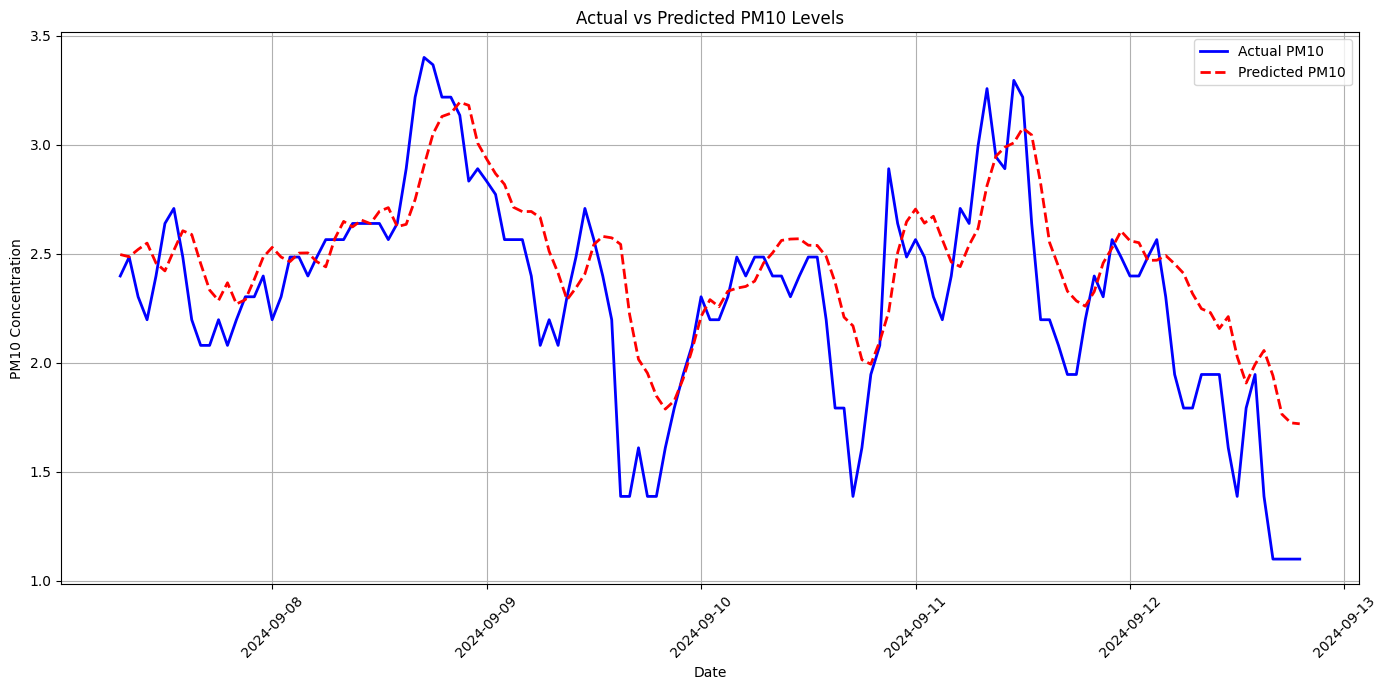

In [ ]:
validation_dates = vdf['datetime'][window_size:].reset_index(drop=True)

plt.figure(figsize=(14, 7))
plt.plot(validation_dates, y_val_actual_inverse, label='Actual PM10', color='blue', linewidth=2)
plt.plot(validation_dates, y_val_pred_inverse, label='Predicted PM10', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted PM10 Levels')
plt.xlabel('Date')
plt.ylabel('PM10 Concentration')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
combined_df = pd.concat([df, vdf], ignore_index=True)

combined_df.sort_values(by=['datetime'], inplace=True)

combined_df.reset_index(drop=True, inplace=True)

combined_df.head()

,datetime,PM10,temperature,rain,pressure,precipitation,wind_speed,clouds_delno oblačno,clouds_jasno,clouds_oblačno,clouds_pretežno oblačno,month,day_of_week,is_weekend,pressure_wind_interaction
0,2024-05-02 20:00:00,1.791759,11.0,0.000000,1008.0,87.0,1.386294,False,False,False,True,5,3,0,8.014666
1,2024-05-02 21:00:00,1.791759,11.0,0.000000,1008.0,87.0,1.386294,True,False,False,False,5,3,0,8.014666
2,2024-05-02 22:00:00,2.197225,11.0,0.336472,1009.0,84.0,2.639057,False,False,False,True,5,3,0,9.481741
3,2024-05-02 23:00:00,2.302585,10.0,0.000000,1009.0,95.0,1.609438,True,False,False,False,5,3,0,8.303257
4,2024-05-03 00:00:00,2.302585,10.0,0.000000,1009.0,93.0,1.386294,True,False,False,False,5,4,0,8.015658


In [ ]:
combined_df.isnull().sum()

,0
datetime,0
PM10,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds_delno oblačno,0
clouds_jasno,0
clouds_oblačno,0


In [ ]:
data = combined_df['PM10']
time_series = data.values.reshape(-1, 1)

combined_scaled = scaler.fit_transform(time_series)

def sliding_window(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 48

X_combined, y_combined = sliding_window(combined_scaled, window_size)

X_combined = X_combined.reshape(X_combined.shape[0], 1, X_combined.shape[1])

In [ ]:
best_lstm_model = recreate_best_lstm_model()

combined_history = best_lstm_model.fit(
    X_combined, y_combined,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

loss = best_lstm_model.evaluate(X_combined, y_combined, verbose=1)
print(f"Loss after retraining on combined data: {loss:.4f}")

best_lstm_model.save("best_lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1165 - val_loss: 0.0146
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0147
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0113
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0087
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0044

Loss after retraining on combined data: 0.0022


['scaler.pkl']

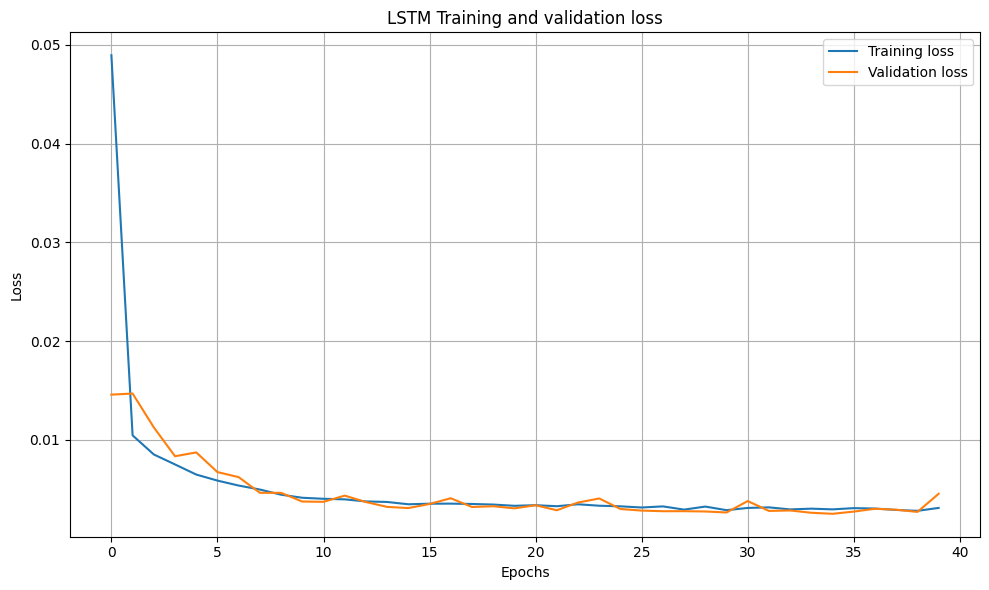

In [ ]:
plot_history(combined_history, 'LSTM')

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

test_df.sort_values(by=['datetime'], inplace=True)
test_df.isnull().sum()

,0
datetime,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds,0


In [ ]:
test_df

,datetime,temperature,rain,pressure,precipitation,wind_speed,clouds
0,2024-09-12 20:00:00,10.0,3.9,1009.0,96.0,10.0,oblačno
1,2024-09-12 21:00:00,9.0,1.6,1010.0,96.0,4.0,oblačno
2,2024-09-12 22:00:00,9.0,2.0,1010.0,96.0,5.0,oblačno
3,2024-09-12 23:00:00,9.0,1.7,1010.0,96.0,5.0,oblačno
4,2024-09-13 00:00:00,9.0,1.4,1010.0,96.0,1.0,oblačno
...,...,...,...,...,...,...,...
176,2024-09-20 04:00:00,14.0,0.0,1021.0,79.0,3.0,pretežno oblačno
177,2024-09-20 05:00:00,14.0,0.0,1021.0,83.0,2.0,pretežno oblačno
178,2024-09-20 06:00:00,14.0,0.0,1021.0,84.0,3.0,delno oblačno
179,2024-09-20 07:00:00,15.0,0.0,1022.0,73.0,2.0,delno oblačno


In [ ]:
test_df = pd.get_dummies(test_df, columns=['clouds'])

test_df['month'] = test_df['datetime'].dt.month
test_df['day_of_week'] = test_df['datetime'].dt.dayofweek
test_df['is_weekend'] = test_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
test_df['pressure_wind_interaction'] = test_df['pressure'] * test_df['wind_speed']

test_df.head()

,datetime,temperature,rain,pressure,precipitation,wind_speed,clouds_delno oblačno,clouds_jasno,clouds_oblačno,clouds_pretežno oblačno,month,day_of_week,is_weekend,pressure_wind_interaction
0,2024-09-12 20:00:00,10.0,3.9,1009.0,96.0,10.0,False,False,True,False,9,3,0,10090.0
1,2024-09-12 21:00:00,9.0,1.6,1010.0,96.0,4.0,False,False,True,False,9,3,0,4040.0
2,2024-09-12 22:00:00,9.0,2.0,1010.0,96.0,5.0,False,False,True,False,9,3,0,5050.0
3,2024-09-12 23:00:00,9.0,1.7,1010.0,96.0,5.0,False,False,True,False,9,3,0,5050.0
4,2024-09-13 00:00:00,9.0,1.4,1010.0,96.0,1.0,False,False,True,False,9,4,0,1010.0


In [ ]:
test_df['rain'] = np.log1p(test_df['rain'])
test_df['wind_speed'] = np.log1p(test_df['wind_speed'])
test_df['pressure_wind_interaction'] = np.log1p(test_df['pressure_wind_interaction'])


minmax = ['rain','precipitation','pressure_wind_interaction']
standard = ['temperature','pressure','wind_speed']

scaler_minmax.fit(test_df[minmax])
scaler_standard.fit(test_df[standard])

In [ ]:
initial_window = combined_scaled[-48:].tolist()
predicted_pm10 = []

for i in range(len(test_df)):
    input_window = np.array(initial_window[-48:]).reshape(1, 1, 48)

    predicted_scaled = best_lstm_model.predict(input_window)
    predicted_pm10_log1p = scaler.inverse_transform(predicted_scaled)[0, 0]
    predicted_pm10_original = np.expm1(predicted_pm10_log1p)
    predicted_pm10.append(predicted_pm10_original)

    new_value_scaled = scaler.transform([[predicted_pm10_log1p]])[0, 0]
    initial_window.append([new_value_scaled])

test_df['PM10'] = predicted_pm10

test_df[['datetime', 'PM10']].to_csv("predicted_PM10.csv", index=False)

print("Predictions saved to 'predicted_PM10.csv'.")